Посмотрим на пример использования библиотеки <a href="https://www.uplift-modeling.com/">scikit-uplift</a>.

На основе материалов <a href="https://habr.com/ru/company/ru_mts/blog/485980/">статей</a> про uplift на Хабре и <a href="https://github.com/maks-sh/scikit-uplift/blob/master/notebooks/RetailHero.ipynb">примера</a>.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold

from sklift.datasets.datasets import fetch_x5
from sklift.metrics import uplift_at_k, uplift_by_percentile
from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.viz import plot_uplift_preds, plot_uplift_by_percentile, plot_qini_curve, plot_uplift_curve

sns.set(style='whitegrid', font_scale=1.5, palette='Set2')
pd.set_option('display.max_columns', None)

In [2]:
import sklift

sklift.__version__

'0.5.1'

Рассмотрим данные с <a href="https://ods.ai/competitions/x5-retailhero-uplift-modeling">конкурса X5 Retail Hero</a>. Данные содержат анонимизированную информацию о клиентах, их покупках за некоторое время. Также в данных содержится информацию о том, совершалось ли на клиента воздействие посредством рекламного SMS, и отклик клиента. Требуется построить модель, определяющую клиентов, которым стоит отправлять SMS. 

Отметим, что в данном случае нам не требуется как можно точнее оценить CATE, требуется скорее определить степерь уверенности того, что клиент совершит покупку из-за получения SMS, или наоборот.

Способы загрузки данных:
1. непосредственно со <a href="https://ods.ai/competitions/x5-retailhero-uplift-modeling">страницы конкура</a>;
2. вызовом <a href="https://www.uplift-modeling.com/en/latest/api/datasets/fetch_x5.html">`data = sklift.datasets.fetch_x5()`</a>

**Но прежде всего обратите внимание, что данные большие, и все целиком они могут не вместиться даже в достаточно большую оперативку, например, в Colab не помещаются.** 


## 1. Задача продвижения продукта

Обычно продвижение продуктов происходит за счет коммуникации с клиентом через различные каналы: смс, push, сообщения чат-бота в социальных сетях и многие другие. Формирование сегментов для продвижения сейчас решается с помощью машинного обучения несколькими способами:
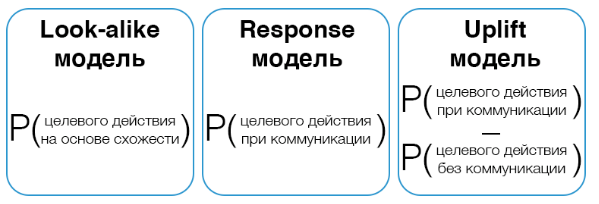

* **Look-alike модель** оценивает вероятность того, что клиент выполнит целевое действие. Такая задача решается классификацией по клиентам. В качестве обучающей выборки используются известные позитивные объекты (например, пользователи, установившие приложение) и случайные негативные объекты (сэмплирование небольшой подвыборки из всех остальных клиентов, у кого это приложение не было установлено). Модель учится на полученном датасете и пытается искать среди оставшихся клиентов, похожих на тех, кто совершил целевое действие. 
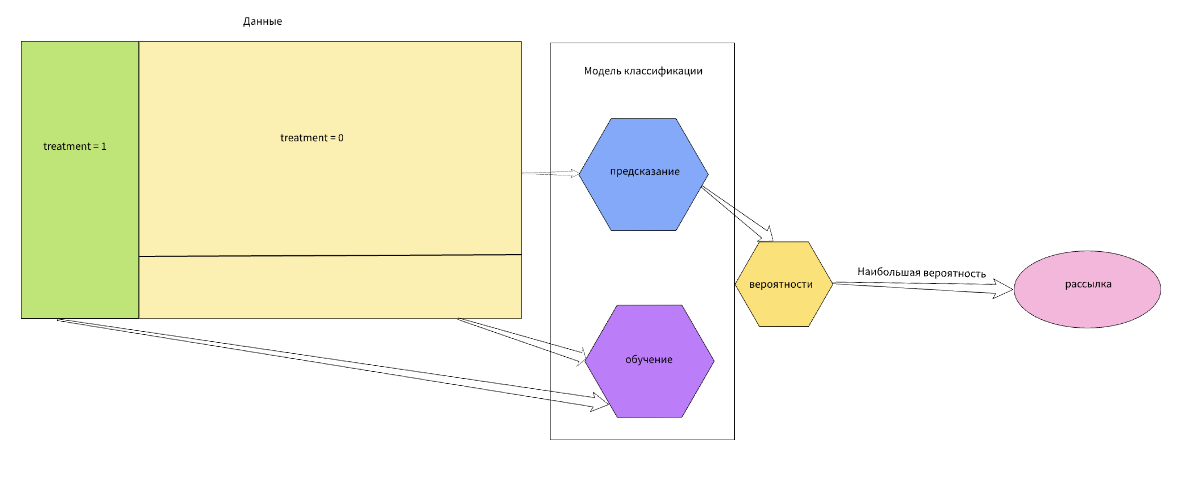
* **Response модель** оценивает вероятность того, что клиент выполнит целевое действие при условии коммуникации. В этом случае обучающей выборкой являются данные, собранные после некоторого взаимодействия с клиентами. В отличии от первого подхода в нашем распоряжении имеются реальные позитивные и негативные наблюдения (например, клиент оформил кредитную карту или отказался).
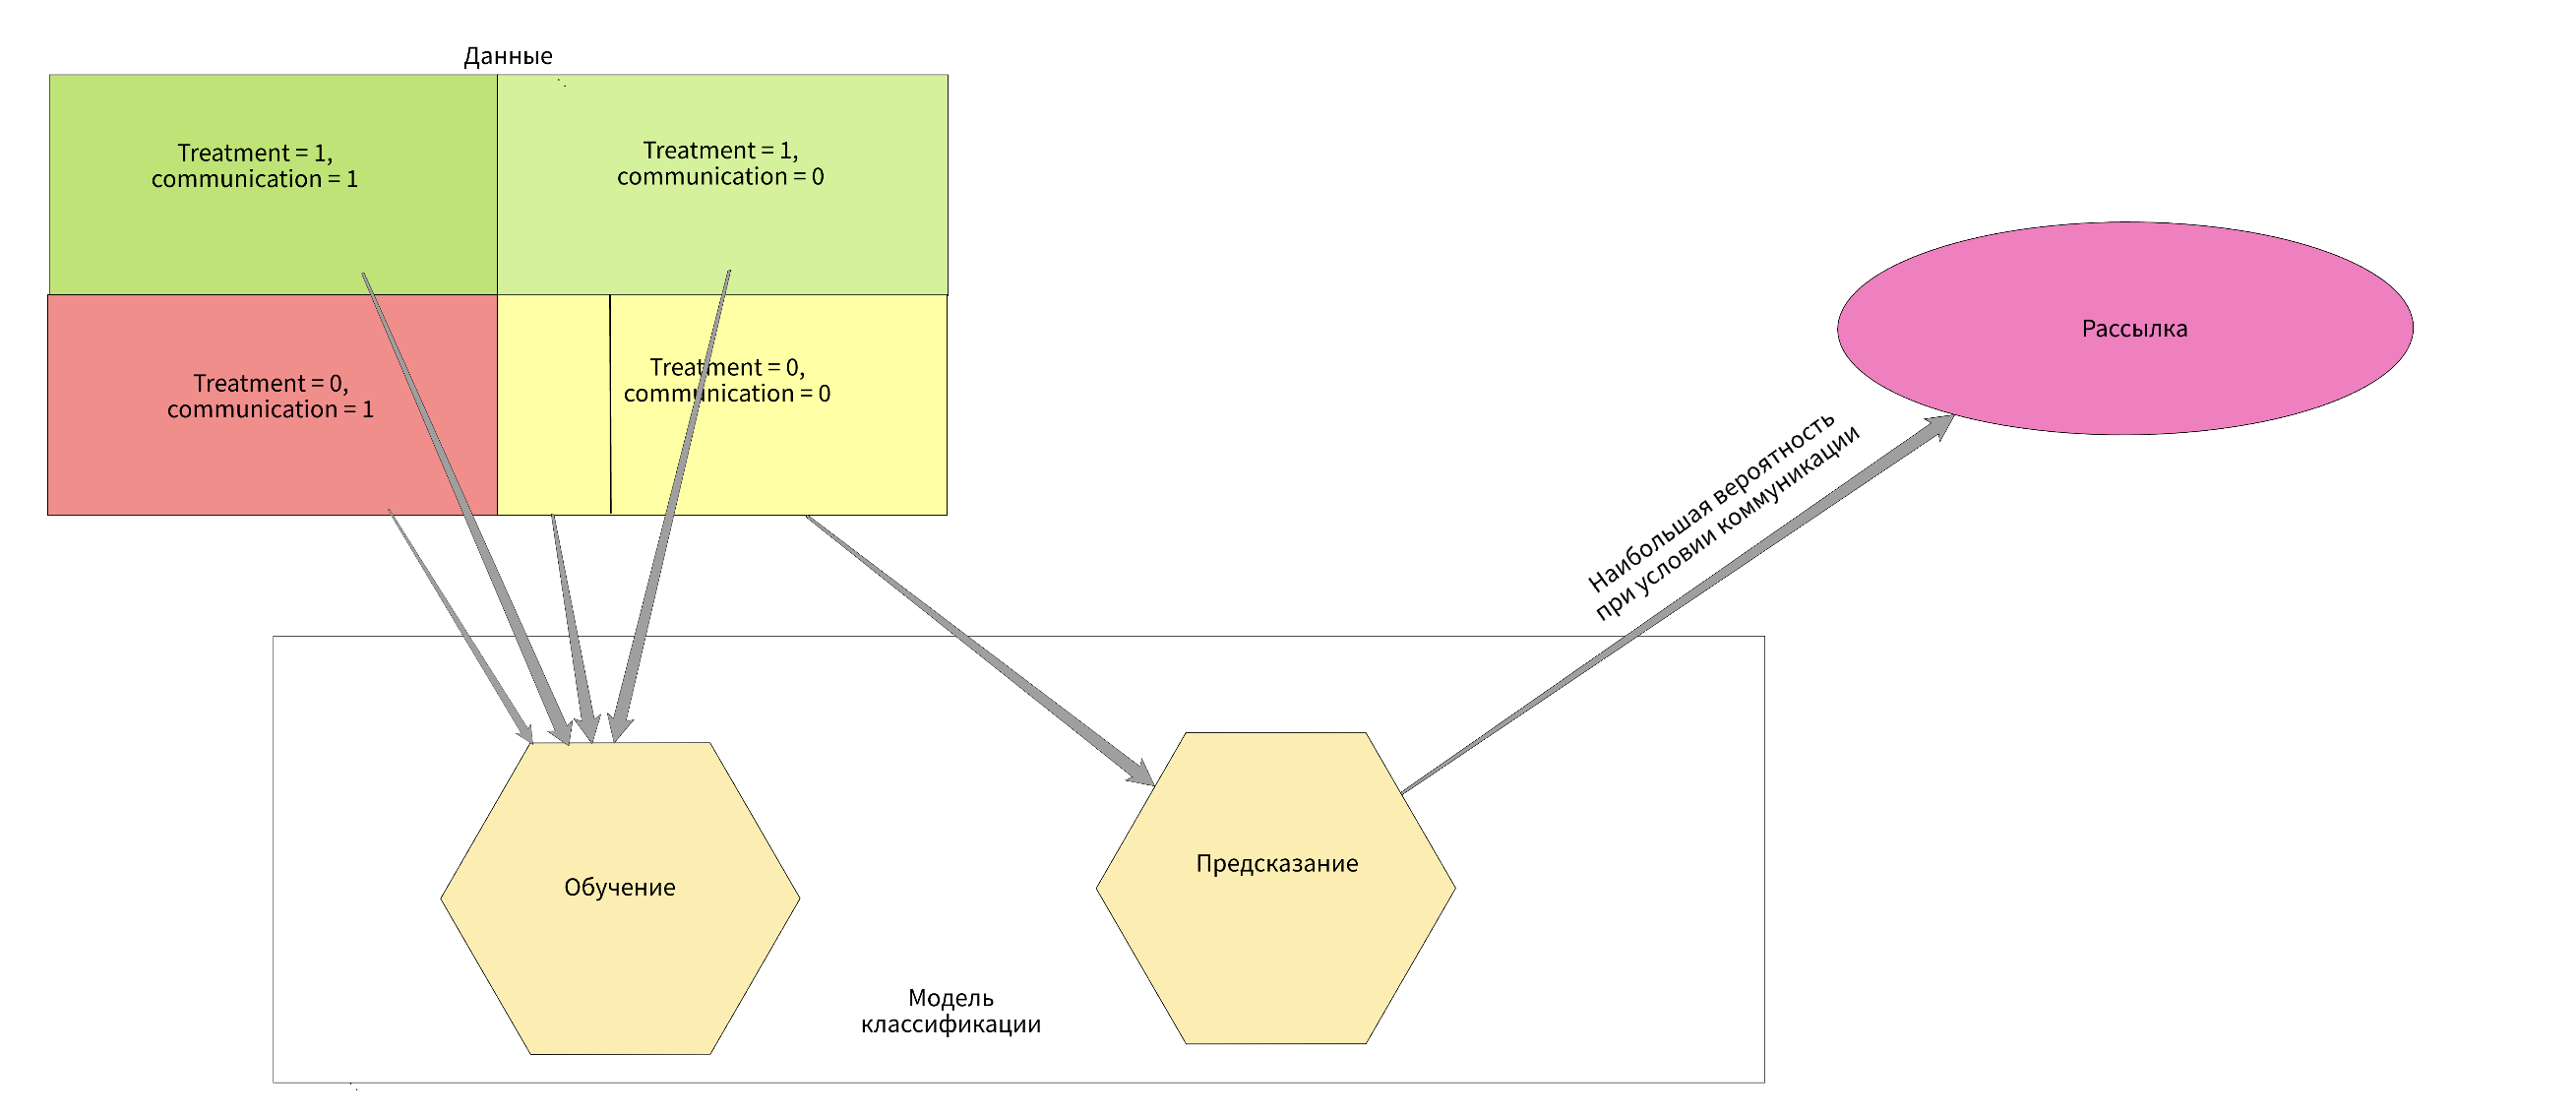
* **Uplift модель** оценивает чистый эффект от коммуникации, пытаясь выбрать только тех клиентов, которые совершат целевое действие только при нашем взаимодействии. Модель оценивает разницу в поведении клиента при наличии воздействия и при его отсутствии, то есть, по сути и оценивает $CATE.$
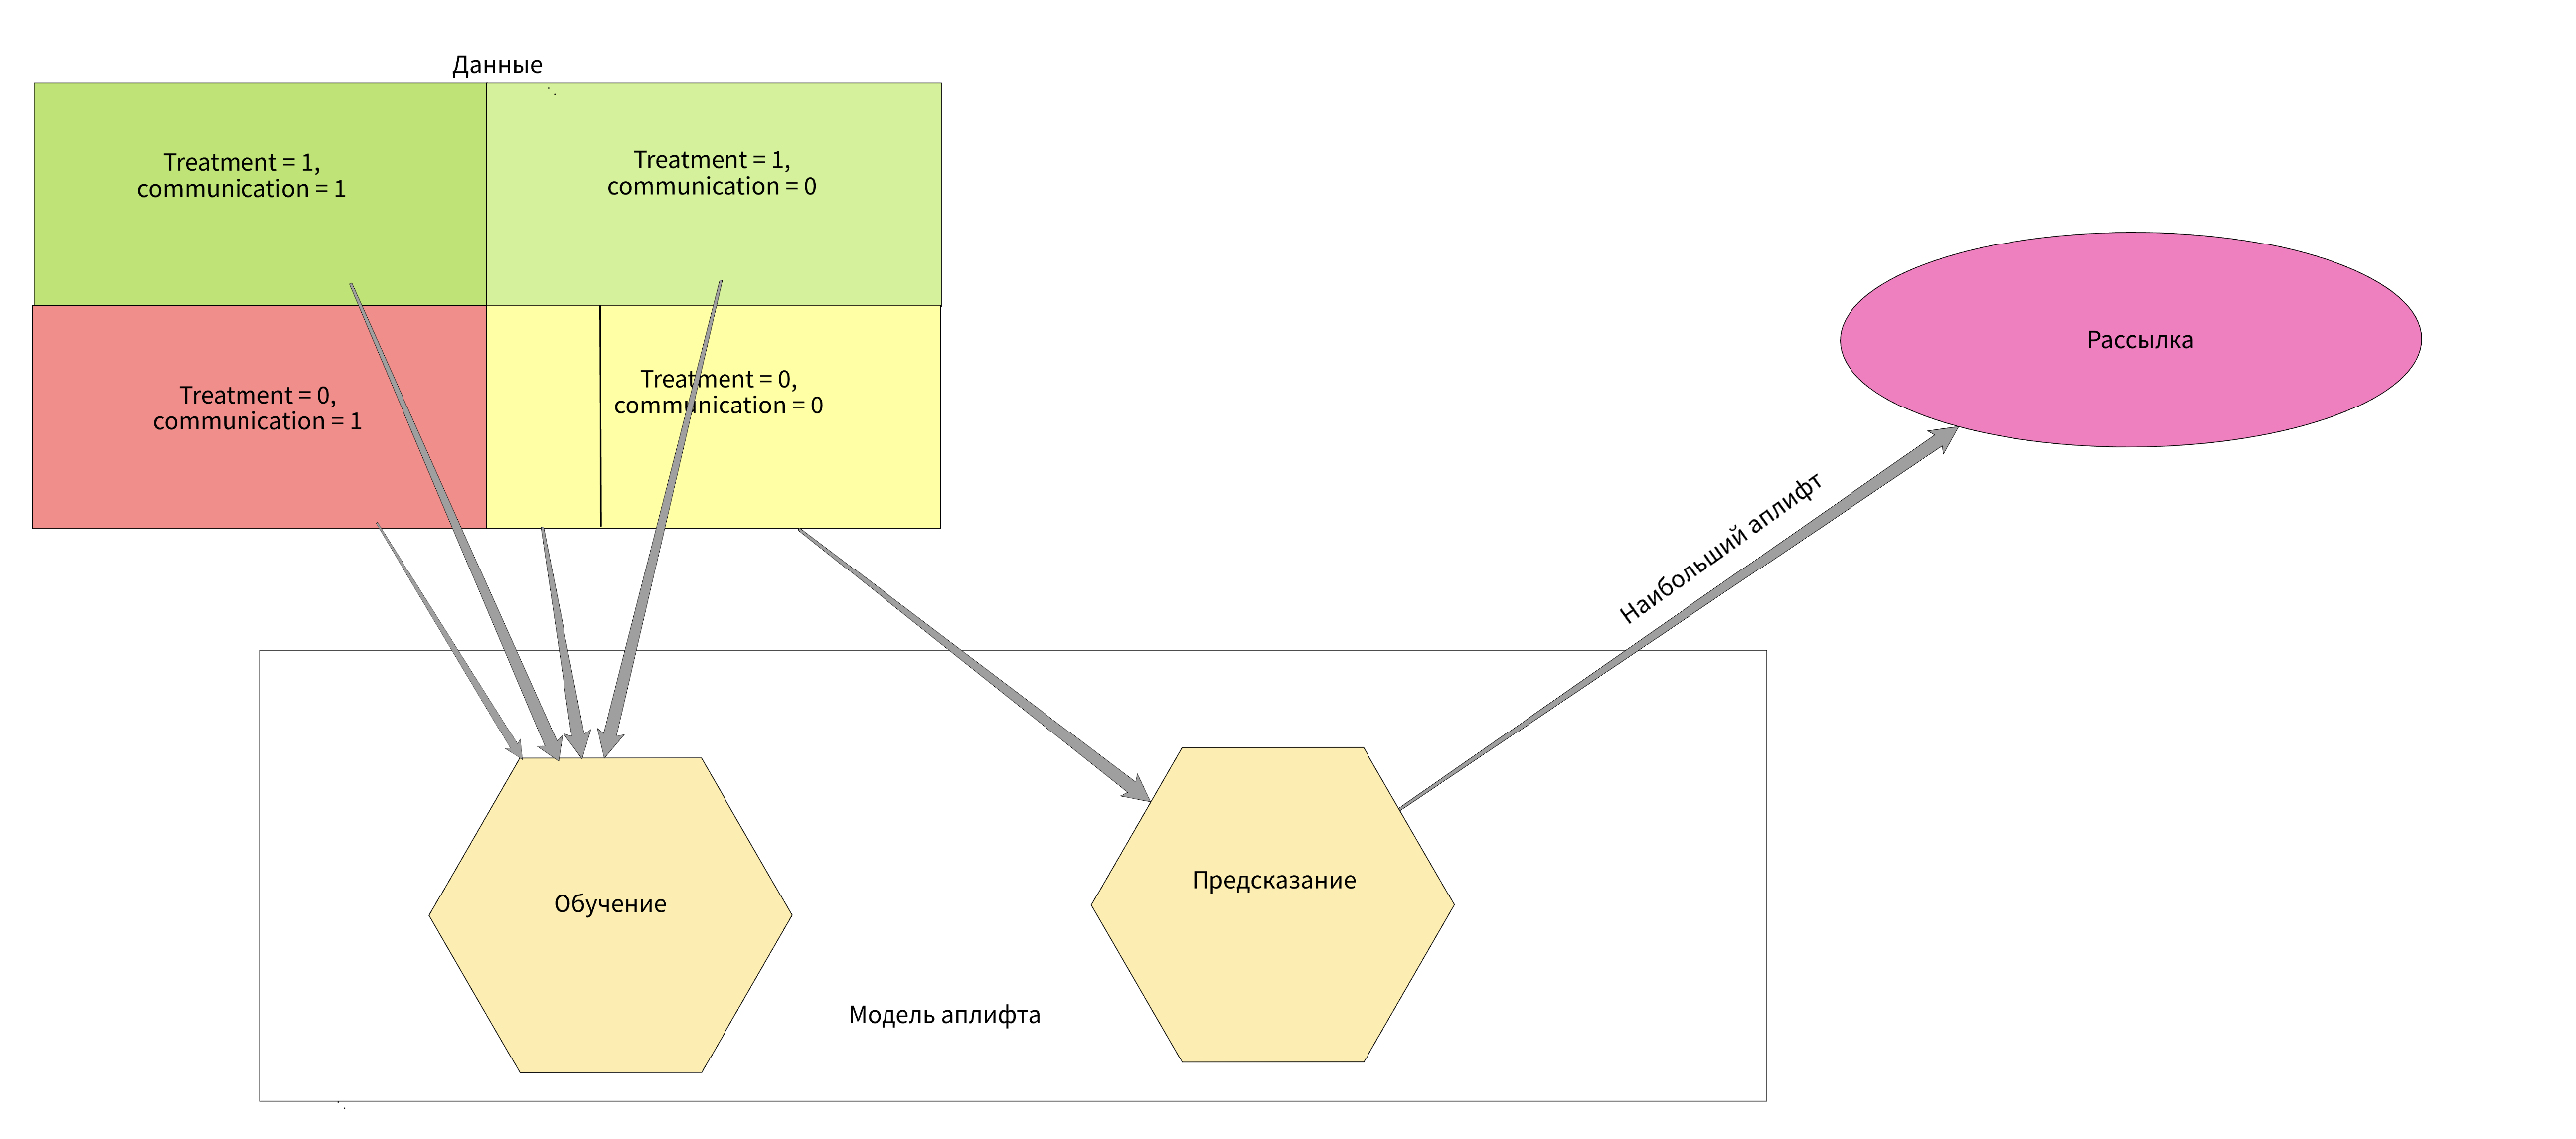

Заметим, что $CATE$ — это то, что нам и нужно: насколько вероятнее клиент совершит таргет-действие (подпишется, что-то купит и т.д.), если мы с ним прокоммуницируем, чем если мы с ним не будем взаимодействовать.

На практике построение модели uplift строится примерно по следующему пайплайну:
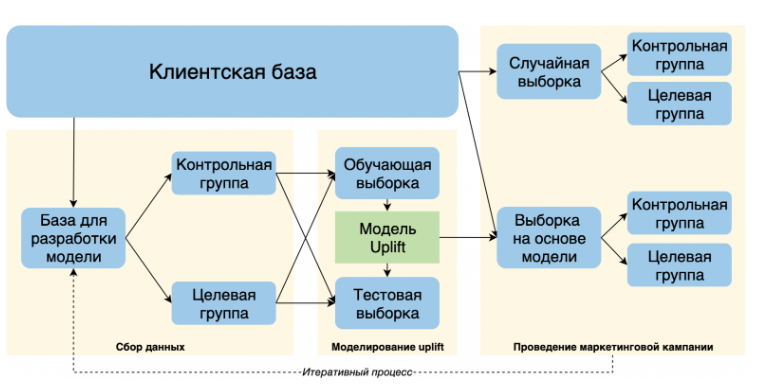
Распишем данный процесс по шагам:
1. Получение обучающей выборки:
    1. Выбрать из выборки клиентской базы подвыборку для обучения модели
    2. Случайным образом разбить репрезентативную часть клиентской базы на целевую и контрольную группы
    3. Запустить пилот маркетинговой кампании на целевую группу
2. Обучение uplift-модели на данных: из тестовой группы получаем пользователей, с которыми прокоммуницировали, из контрольной — с которыми не взаимодействовали
3. Предсказываем на оставшейся клиентской базе, выделяем пользователей с наибольшим аплифтом, а также случайных пользователей
4. Делим каждую из групп на тест и контроль, с тестом взаимодействуем, с контролем — нет. 
5. Собираем результаты: сравнение аплифта пользователей, выделенных моделью, и случайных дает нам оценку работы модели на практике, а сам аплифт на пользователях, выделенных моделью, дает нам искомый эффект от коммуникаций

Рассмотрим построение uplift-модели на примере.

---

## 2. Загрузка и преобразование данных

Данные о клиентах

In [3]:
data_clients = pd.read_csv('retailhero-uplift/data/clients.csv', index_col=0)
data_clients.head()

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaN,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


In [4]:
data_clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400162 entries, 000012768d to fffff6ce77
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   first_issue_date   400162 non-null  object
 1   first_redeem_date  364693 non-null  object
 2   age                400162 non-null  int64 
 3   gender             400162 non-null  object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB


Данные по эксперименту: 
* `treatment_flg` &mdash; было ли отправлено клиенту SMS;
* `target` &mdash; совершил ли клиент покупки после этого.

In [5]:
data_train = pd.read_csv('retailhero-uplift/data/uplift_train.csv', index_col=0)
data_train.sample(10)

,treatment_flg,target
client_id,,
da2fceffb5,0,1
b5d08508ef,0,1
1dc1dfe295,1,1
c15ba79c8e,0,1
76e623fda6,0,0
3b58620e8d,0,1
e0df94959d,0,1
04a5de0824,0,1
63571ea71e,0,1


Как видим, в данных есть чуть более 400к клиентов, для половины из них предоставлена информация о результатах отправки рекламы.

In [6]:
data_clients.shape, data_train.shape

((400162, 4), (200039, 2))

Также имеются данные о покупках клиентов. Файл очень большой, полностью мы его загружать не будем, а также не будем учитывать его при анализе. 

Всего в данных имеется 45 миллионов записей, причем каждая запись представляет собой одну позицию в чеке покупки. Например, по началу таблицы мы видим, что клиент `000012768d` соверших покупку в `2018-12-01 07:12:45	` в магазине `54a4a11a29` на сумму 1007 рублей (колонка `purchase_sum`). Его чек имеет идентификатор `7e3e2e3984`, всего в нем 19 позиций, т.е. 19 уникальных товаров, зашифрованными в колонке `product_id`, количество каждого товара и стоимость указаны в колонках `product_quantity` и `trn_sum_from_iss` соответственно.

In [7]:
pd.read_csv('retailhero-uplift/data/purchases.csv', nrows=30)

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN
5,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,21db5dbe53,1.0,34.0,NaN
6,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,1e208d0b4c,1.0,24.0,NaN
7,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,15ccaa8685,1.0,51.0,NaN
8,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,45389bb5b0,1.0,23.0,NaN
9,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,cb4c804130,1.0,60.0,NaN


Извлечем некоторые признаки: преобразуем даты в числа, а также посчитаем их разницу.

In [8]:
df_features = data_clients.copy()

df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']

df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

df_features.head()

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
000012768d,45,U,1501947648,1.515094e+09,13146559.0
000036f903,72,F,1491832463,1.492951e+09,1118613.0
000048b7a6,68,F,1544880791,NaN,NaN
000073194a,60,F,1495544174,1.511522e+09,15978107.0
00007c7133,67,U,1495469828,1.546277e+09,50806825.0


Оставим часть данных для валидации, а также выделим матрицы для удобства работы

In [9]:
indices_learn, indices_valid = train_test_split(data_train.index, test_size=0.3, random_state=123)

X_train = df_features.loc[indices_learn, :]
y_train = data_train.loc[indices_learn, 'target']
treat_train = data_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = data_train.loc[indices_valid, 'target']
treat_val = data_train.loc[indices_valid, 'treatment_flg']

cat_features = ['gender']

Получаем следующее признаковое описание. Отметим, что мы вообще не использовали информацию о покупках, то есть хорошего качества моделей в данном случае ожидать не приходится.

In [10]:
X_train.head()

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
ad6561e2d8,50,F,1512322431,1.527102e+09,14779510.0
7c1ccbf93f,24,F,1510331629,1.519326e+09,8994516.0
b58fadcab6,36,U,1509657465,1.537045e+09,27387871.0
e99e6fabb9,79,F,1526466080,1.527713e+09,1247284.0
27fb6f8520,34,F,1500320188,1.513332e+09,13012137.0


Таргет

In [11]:
y_train.head()

client_id
ad6561e2d8    1
7c1ccbf93f    1
b58fadcab6    1
e99e6fabb9    0
27fb6f8520    1
Name: target, dtype: int64

Тритмент

In [12]:
treat_train.head()

client_id
ad6561e2d8    1
7c1ccbf93f    1
b58fadcab6    1
e99e6fabb9    0
27fb6f8520    1
Name: treatment_flg, dtype: int64

## 3. Модели

### 3.1 Трансформация классов

In [13]:
ct = ClassTransformation(
    CatBoostClassifier(iterations=50, thread_count=2, random_state=42, silent=True)
)
ct = ct.fit(
    X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features}
)

uplift_ct = ct.predict(X_val)
uplift_ct

array([-0.00259072,  0.04377983,  0.07420515, ..., -0.04837402,
        0.01514164, -0.01513564])

### 3.2 S-learner

По сути является оберткой над sklearn-подобной моделью

In [14]:
sm = SoloModel(
    CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True)
)
sm = sm.fit(
    X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features}
)

uplift_sm = sm.predict(X_val)
uplift_sm

array([ 0.00410676,  0.02876891,  0.03665736, ..., -0.00138501,
        0.04377581,  0.005103  ])

Условные вероятности совершения клиента при взаимодействии для каждого клиента

In [15]:
sm.trmnt_preds_

array([0.33540886, 0.75178928, 0.63891482, ..., 0.58466895, 0.6467836 ,
       0.64817784])

Условные вероятности совершения клиента без взаимодействия для каждого клиента

In [16]:
sm.ctrl_preds_

array([0.3313021 , 0.72302036, 0.60225747, ..., 0.58605396, 0.6030078 ,
       0.64307483])

Uplift это их разность

In [17]:
sm.trmnt_preds_ - sm.ctrl_preds_

array([ 0.00410676,  0.02876891,  0.03665736, ..., -0.00138501,
        0.04377581,  0.005103  ])

Построим на распределение этих величин

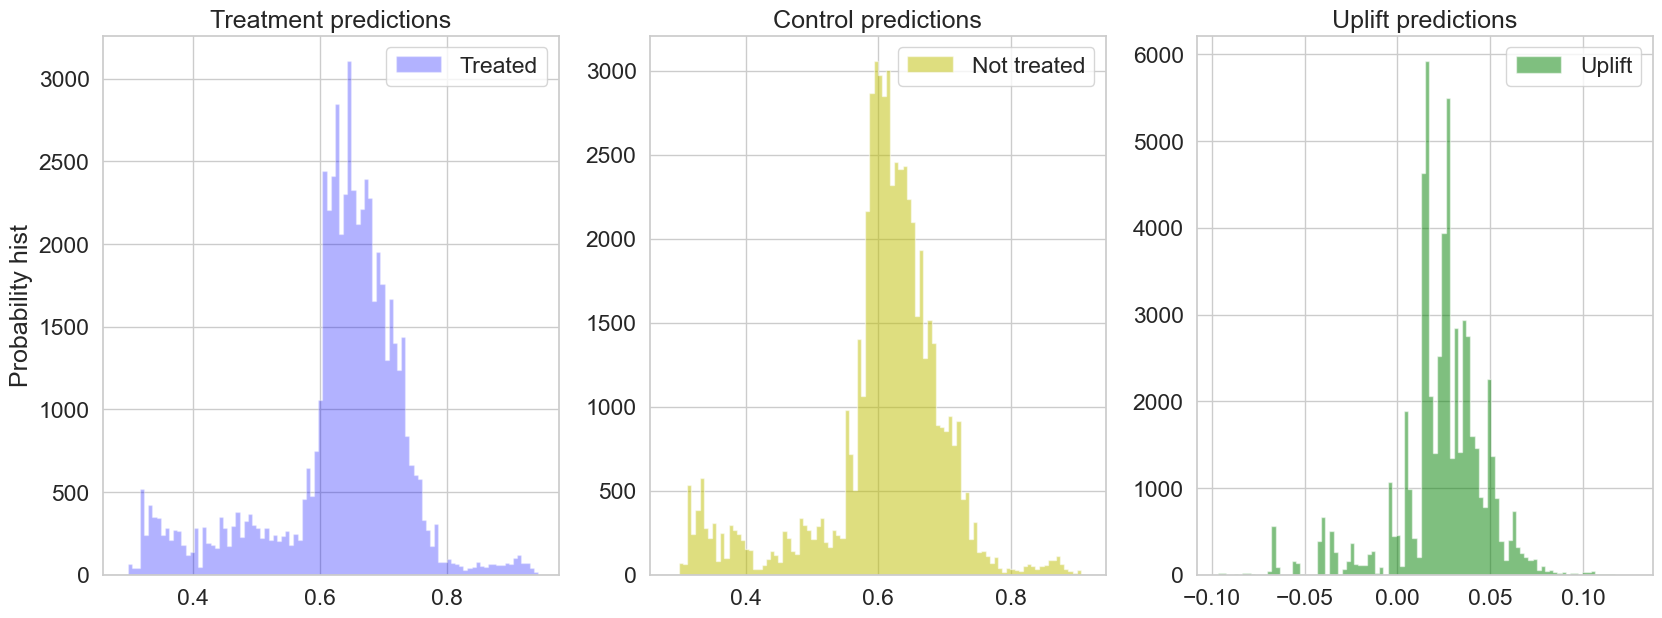

In [18]:
plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_);

Распределение предсказанного аплифта не очень похоже на нормальное. Заметим также, что модель редко предсказывает отрицательный аплифт

Можно обратиться напрямую к обученной модели, например, чтобы построить важность признаков

In [20]:
pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

,feature_name,feature_score
0,first_redeem_time,42.879412
1,issue_redeem_delay,40.498781
2,age,7.298736
3,first_issue_time,4.878425
4,treatment,3.146585
5,gender,1.298059


### 3.3 T-learner

In [21]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

Посмотрим на результаты

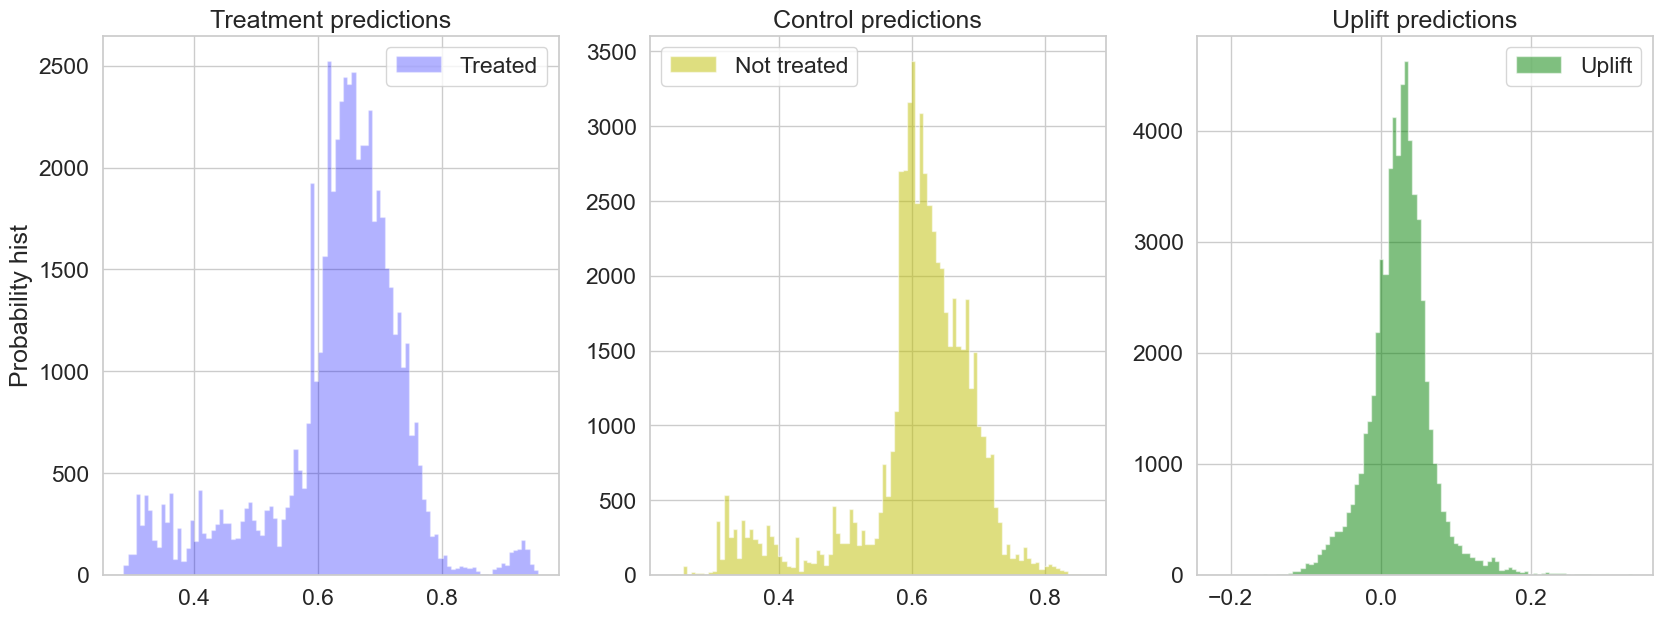

In [22]:
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Распределение аплифта похоже на нормальное, а также есть значительная доля отрицательно предсказанных аплифтов

## 4. Метрики качества

### 4.1 uplift@k
Самая простая и понятная метрика &mdash; размер uplift на топ $k$ процентах выборки. Например, с помощью обученной uplift модели мы хотим отобрать какое-то количество клиентов, с которыми будем коммуницировать. Пусть бюджет рассчитан на $k$% клиентов. Тогда нам интересно оценить качество прогноза не на всей тестовой выборке, а только на объектах с наибольшими предсказаниями при отсечении по порогу в $k$ процентов.

**Смысл:** uplift@k — это оценка результатов аб-теста при условии того, что мы будем проводить аб на топ-$k$ процентах клиентов по предсказанному аплифту.

Для вычисления uplift@k нужно отсортировать выборку по величине предсказанного uplift и посмотреть разницу средних значений таргета при единичном и нулевом тритменте

In [23]:
uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

0.06177490256503215

Теоретический uplift@k принимает значения 
* от $-1$: *когда в целевой группе нет реакций $Y=1$, а в контрольной группе все клиенты имеют реакцию $Y=1$*
* до $1$: *в целевой группе все клиенты откликнулись: $Y=1$, в то время как в контрольной &mdash; ни одного случая с $Y=1$*.

На практике uplift@k принимает значения от $0$ до $1$, в зависимости от выбранного значения $k$, особенностей датасета и качества модели.

### 4.2 Uplift by percentile
Бывает так, что со стороны бизнеса не известно значение порога $k$ и хочется посмотреть, как будет вести себя метрика при разных значениях порога k. 

**Смысл:** на основе таблички можно оценить, на какие из групп эффективно воздействовать: отобрать первые бины, пока аплифт достаточно большой, и воздействовать именно на эти группы.

При построении действуем по аналогии с uplift@k:

1. Сортируем по предсказанному значению uplift.
2. Делим отсортированные данные на перцентили / децили / бины.
3. В каждом перцентиле отдельно оцениваем uplift как разность между средними значениями целевой переменной в тестовой и контрольной группах.

Результатом этой метрики, как правило, является таблица или ее визуальное представление в виде графика.

В таблице указаны:
* количество объектов в тесте и в контроле для данного бина
* средний отклик в тесте и в контоле
* их разница: uplift
* стандартное отклонение для среднего отклика и uplift

In [23]:
uplift_sm

array([ 0.00410676,  0.02876891,  0.03665736, ..., -0.00138501,
        0.04377581,  0.005103  ])

In [24]:
uplift_by_percentile(y_val, uplift_sm, treat_val, 
                     strategy='overall', 
                     std=True, bins=10)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
10.0,3076,2926,0.710988,0.643882,0.067106,0.008173,0.008852,0.012049
20.0,3151,2851,0.708029,0.652052,0.055977,0.008100,0.008921,0.012049
30.0,3046,2955,0.676297,0.610491,0.065806,0.008478,0.008971,0.012343
40.0,2984,3017,0.690684,0.678820,0.011864,0.008461,0.008501,0.011994
50.0,3030,2971,0.616172,0.597105,0.019066,0.008835,0.008998,0.012611
60.0,2971,3030,0.603164,0.580858,0.022306,0.008976,0.008964,0.012685
70.0,2966,3035,0.643291,0.593740,0.049551,0.008796,0.008915,0.012524
80.0,2942,3059,0.657036,0.632560,0.024476,0.008752,0.008717,0.012352
90.0,2986,3015,0.555593,0.537977,0.017616,0.009093,0.009080,0.012850


Таблицу можно визуализировать. Величина закрашенной области это и есть uplift.



/home/nikita/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


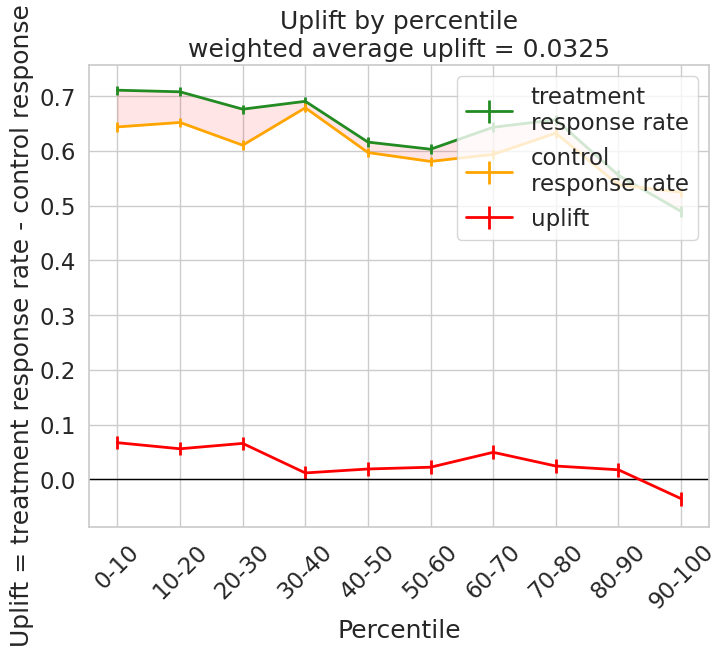

In [22]:
plot_uplift_by_percentile(y_val, uplift_sm, treat_val, strategy='overall', kind='line');

Так как коммуникация будет проводиться с клиентами, получившими наибольшую оценку uplift, то слева на графике должны быть максимальные по модулю положительные значения uplift и в следующих перцентилях значения уменьшаются.

Можно также использовать другой способ представления

/home/nikita/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


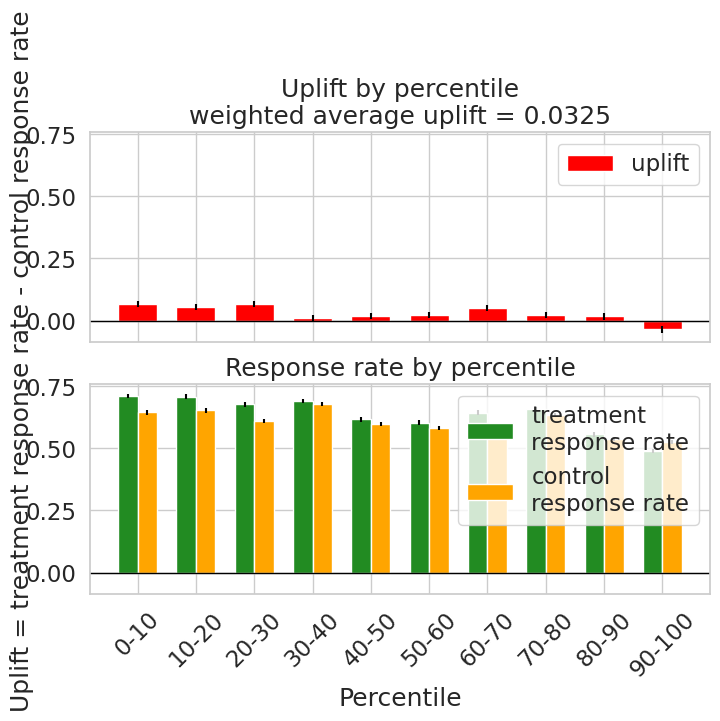

In [23]:
plot_uplift_by_percentile(y_val, uplift_sm, treat_val, strategy='overall', kind='bar');

Вспомним разделение по типам клиентов. Можно сказать, что в левой части графика находятся **убеждаемые** &mdash; тот тип, которых мы хотим найти. На графике могут быть и отрицательные значения uplift. Нетрудно понять, что это случится в том перцентиле, в котором отклик в контрольной группе больше, чем в целевой. Это значит, что коммуникация с этой группой имела негативный эффект и модель нашла тип клиентов, которые негативно реагируют на коммуникацию &mdash; тип **не беспокоить**.

На графике между типом убеждаемые в левой части и типом не-беспокоить в правой части лежат два оставшихся типа, которые модель не различает между собой: **лояльные** и **потерянные**.

Для случайной аплифт модели график uplift by percentile будет выглядеть как линия, параллельная оси Х.

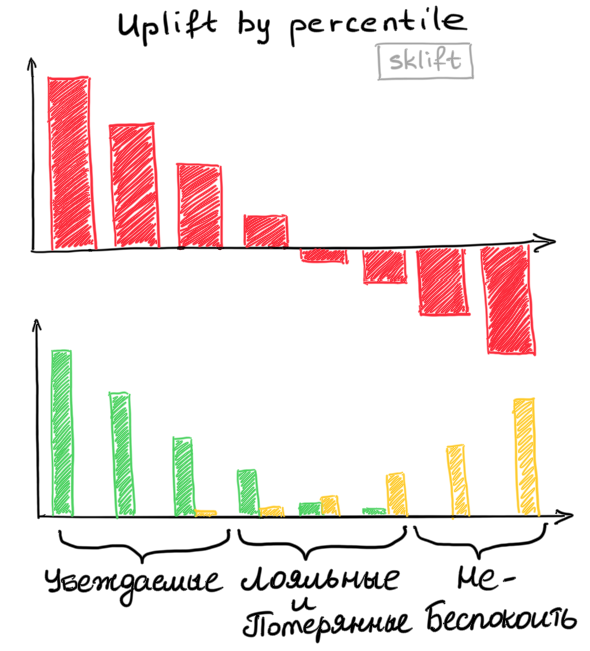

### 4.3  `Qini curve`


Построение происходит следующим образом.
1. Отсортировать объекты по убыванию предсказанного значения uplift.
2. Для каждого $k$ от 1 до кол-ва объектов:
    * по объектам от 1 до $k$ посчитать сумму таргета в тестовой и контрольной группах (если объектов в группе еще нет, то сумма равна 0),
    * отнормировать сумму в контрольной группе на количество объектов в тествой группе (домножить на отношение количества объектов)
    * взять разность полученных значений.

Кроме кривой для конкретной модели стоят также другие кривые:

* Идеальная кривая:
    * "не беспокоить:" $y(t = 1) = 0, \ y(t = 0) = 1, \ \Rightarrow uplift = -1$
    * "лояльные:" $y(t = 1) = 1, \ y(t = 0) = 1, \ \Rightarrow uplift = 0$
    * "потерянные:" $y(t = 1) = 0, \ y(t = 0) = 0, \ \Rightarrow uplift = 0$
    * "убеждаемые:" $y(t = 1) = 1, \ y(t = 0) = 0, \ \Rightarrow uplift = 1$

    Таким образом, идеальная модель расположит сначала всех убеждаемых, потом — лояльных и потерянных, и, наконец, пользователей из категории "не беспокоить", поэтому кривая сначала идет под коэффициентом наклона 1, потом не меняется и, наконец, убывает с коэффициентом наклона -1
* Кривая случайной модели: в среднем определяется как суммарный эффект по всем данным, нормированной на размер подвыборки

#### Qini coefficient или Area under qini curve (AUQC)

Для сравнения моделей предлагается вычислять площадь под кривой модели и нормировать ее на площадь под идеальной кривой. При этом обычно из этих площадей вычитают площадь под случайной кривой, которую называют baseline.


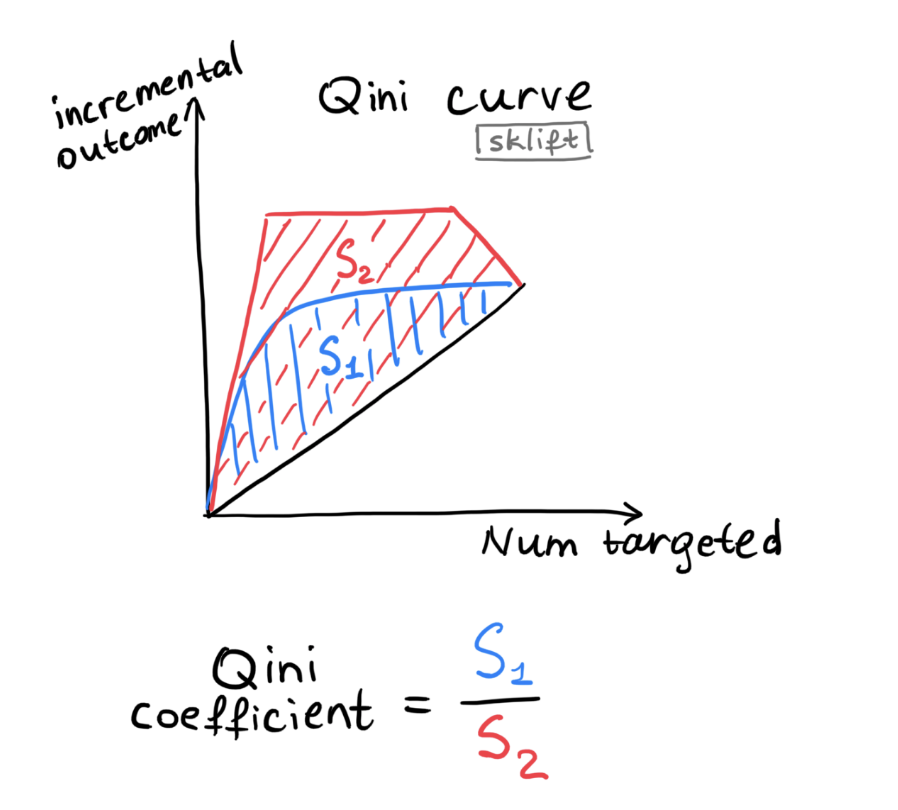

---

Посмотрим на кривые для наших моделей

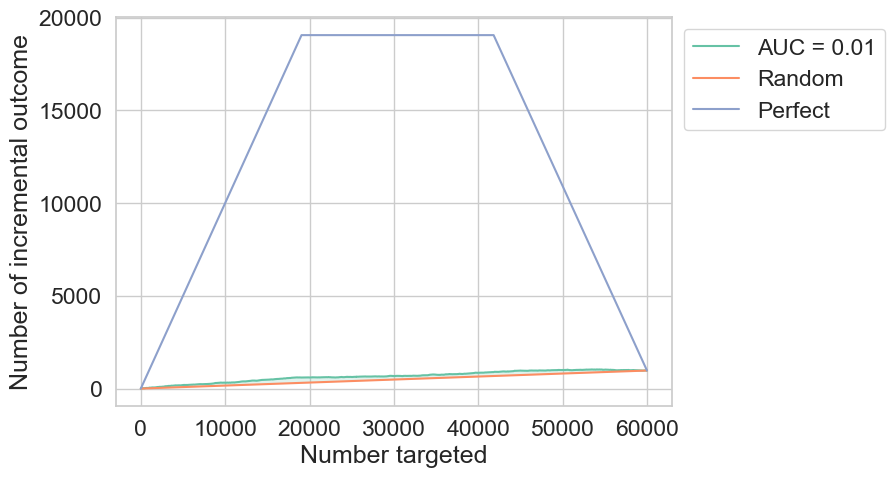

In [253]:
plot_qini_curve(y_val, uplift_sm, treat_val, perfect=True);

Для наглядности уберем кривую идеальной модели

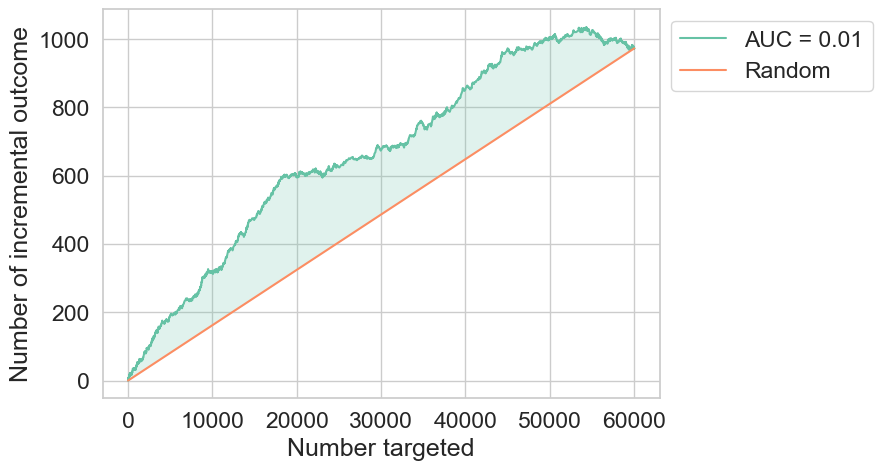

In [254]:
plot_qini_curve(y_val, uplift_sm, treat_val, perfect=False);

Посчитаем также AUQC

In [255]:
qini_auc_score(y_val, uplift_sm, treat_val) 

### 4.4 `Uplift curve` 

Uplift кривая строится как функция от количества объектов, нарастающим итогом. В каждой точке кривой можно увидеть накопленный к этому моменту uplift. 

Построение происходит следующим образом.
1. Отсортировать объекты по убыванию предсказанного значения uplift.
2. Для каждого $k$ от 1 до кол-ва объектов:
    * посчитать uplift по объектам от 1 до $k$ как разность средних между тестовой и контрольной группами (если объектов в группе еще нет, то среднее равно 0),
    * домножить полученное значение на $k$.

Кроме кривой для конкретной модели стоят также другие кривые:
* кривая случайной модели, которая в среднем определяется как ATE по всем данным, домноженной на размер подвыборки,
* кривая идеальной модели, которая строится на основе истинной реакции в валидационной выборке:
    * сначала ставятся убеждаемые клиенты, и кривая монотонно растет при увеличении доли клиентов;
    * затем лояльные и потерянные, и кумулятивный uplift начинает уменьшаться;
    * наконец, клиенты не-беспокоить, и uplift уменьшается еще сильнее.
    
**Смысл:** можно посмотреть на кривую и понять, с какого момента аплифт перестает расти или растет недостаточно сильно. Например, если наш способ взаимодействия — коммуникация, а таргет — конверсия в подписку, то можно оценить, сколько мы тратим на коммуникацию с клиентом, какой аплифт нам приносит клиент с таким-то предсказанным аплифтом и найти момент, с которого нам невыгодно коммуницировать с клиентами.

Также можно из любой точки uplift-кривой оценить прирост в таргет-действиях от коммуникаций, так как по сути любая точка кривой имеет координаты (число пользователей с коммуникациями, прирост в таргет-действиях от коммуникаций). Из этого легко перейти в оценку денежного эффекта: надо умножить на разность стоимости таргет-действия и стоимости коммуникации с клиентом.
    
#### Area under uplift curve, AUUС

Считается аналогично AUQC

---

Посмотрим на кривые для наших моделей

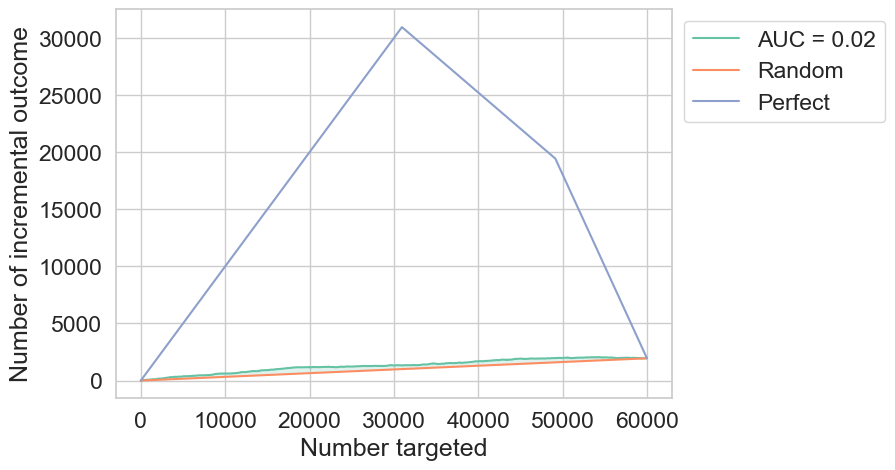

In [256]:
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=True);

Для наглядности уберем кривую идеальной модели

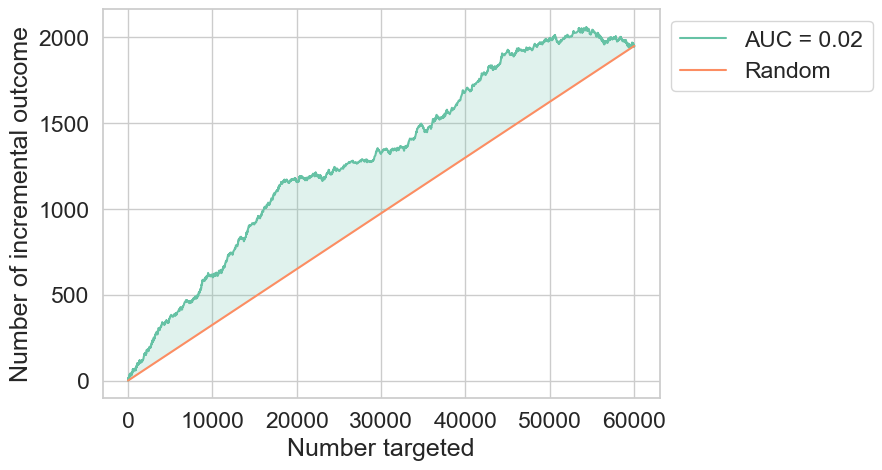

In [257]:
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False);

Посчитаем также AUUC

In [258]:
uplift_auc_score(y_val, uplift_sm, treat_val)

## 5. Сравнение моделей

Посчитаем метрики для моделей, которые мы обучили

In [259]:
models_results = {
    'model': ['S-learner', 'T-learner', 'ClassTransformation'],
    'uplift@30%': [],
    'AUQC': [],
    'AUUC': []
}

for uplift in [uplift_sm, uplift_tm, uplift_ct]:
    models_results['uplift@30%'].append(
        uplift_at_k(y_true=y_val, uplift=uplift, treatment=treat_val, strategy='by_group', k=0.3)
    )
    models_results['AUQC'].append(
        qini_auc_score(y_true=y_val, uplift=uplift, treatment=treat_val) 
    )
    models_results['AUUC'].append(
        uplift_auc_score(y_true=y_val, uplift=uplift, treatment=treat_val)
    )

In [260]:
pd.DataFrame(data=models_results).sort_values('AUUC', ascending=False)

,model,uplift@30%,AUQC,AUUC
1,T-learner,0.049684,0.014258,0.020507
0,S-learner,0.061775,0.013740,0.019892
2,ClassTransformation,0.053850,0.011834,0.016871


По AUQC и AUUC наилучшие результаты показывает T-learner, а по uplift@30% лучше оказался S-learner.